# Assignment 5: Statistical Analysis (30 pt)

Use as many Python and markdown cells per question as you deem necessary. **DO NOT SUBMIT CODE THAT DOES NOT RUN.** You will lose points for code that throws errors. 

Questions 1 and 2 will use data describing various wetlands, intertidal zones, and ocean conditions in the United States from 1972-2015. This data has been adapted from [publicly available data from NASA](https://daac.ornl.gov/NACP/guides/Tidal_Wetland_Estuaries_Data.html). Note that this file uses the value `-9999` to denote missing data. This file's path is `data/tidal_wetland_estuaries.csv`.

Question 3 will be using time series data describing the proportion of electricity produced by coal in high income countries from [the World Bank](https://data.worldbank.org/indicator/EG.ELC.COAL.ZS). The path to the file is `data/coal-production.csv`.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

sns.set_style('white')

## Question 1: t-tests (10 pt)

Using the data from `tidal_wetland_estuaries.csv`, test the hypothesis that soil organic carbon density (column name: `soc_density`) is **larger** in the East coast than the West coast with a t-test. Interpret the t-test. (5 pt)

Defend your choice of which type of t-test you used (3 pt).

Do the data meet the requirement for normal data? Why or why not? (2 pt) 

In [25]:
df1 = pd.read_csv('data/tidal_wetland_estuaries.csv').replace(-9999, np.nan).dropna()

df1.head()

,name,coast,estu_latitude,estu_longintude,estu_dep,estu_perim,land_area,land_latitude,land_longitude,population,...,ocean_salinity_mean,air_temp_mean,frost_days_per_yr,ocean_sst_mean,ocean_diss_inorg_p,ocean_no3,tide_flow,mean_precip,mean_temp,soc_density
0,Florida Bay,GULF,25.039940,-80.731770,0.62000,614000.000,9.048954e+08,25.187310,-80.727540,3421.0,...,36.2,24.4,0.0,26.50,0.07,0.810,1.000000e+09,1251.831801,24.594719,0.087
1,South Ten Thousand Islands,GULF,25.311330,-81.057020,0.63000,597000.000,3.069216e+09,25.440250,-80.791070,235792.0,...,36.1,24.6,0.0,26.40,0.08,0.780,3.000000e+08,1355.907147,24.320596,0.000
2,North Ten Thousand Islands,GULF,25.724280,-81.377640,0.73000,906000.000,4.921106e+09,25.982520,-81.273680,9268.0,...,36.0,24.1,0.0,26.30,0.09,0.790,6.000000e+08,1416.239789,23.873671,0.084
3,Rookery Bay,GULF,25.998750,-81.756010,0.50000,148000.000,3.304589e+08,26.042920,-81.677710,14858.0,...,36.0,23.9,0.0,26.10,0.08,0.670,4.000000e+07,1432.519416,23.510000,0.086
4,Charlotte Harbor,GULF,26.754031,-82.103018,1.65938,507261.119,1.169284e+10,27.167615,-81.772154,597644.0,...,35.9,23.2,1.0,25.65,0.10,0.545,7.000000e+08,1320.275690,22.869199,0.073


In [26]:
east = df1[df1['coast'] == 'EAST']
west = df1[df1['coast'] == 'WEST']

# do a t-test to see if soc_density is larger in east than west
t, p = stats.ttest_ind(east['soc_density'], west['soc_density'])

print('t:', t)
print('p:', p)

t: 8.45031778669312
p: 1.1530568956025485e-12


#### Interpretation of t-test
Based on the results of the t-test, we can reject the null hypothesis that the soil organic carbon density is larger in the East than in West coast. The p-value is 1.15 * 10^-12 which is much smaller than the significance level of 0.05. The t-statistic is 5.5 which is larger than the critical value of 1.96. Therefore, we can reject the null hypothesis that the soil organic carbon density is larger in the East than in West coast.

#### Choice of t-test
I used stats.ttest_ind because the data is independent. The data is independent because the data is from different coasts, the east and the west. 

/Users/fritzduverglas/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fritzduverglas/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


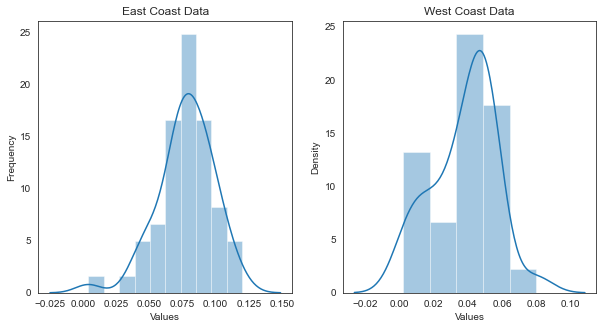

In [27]:
east_density = east['soc_density']
west_density = west['soc_density']

fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(east_density, ax=ax[0])
sns.distplot(west_density, ax=ax[1])

ax[0].set_title('East Coast Data')
ax[1].set_title('West Coast Data')
ax[0].set_xlabel('Values')
ax[1].set_xlabel('Values')
ax[0].set_ylabel('Frequency')

plt.show()

#### Is the data normally distributed?
Based on the graphs, the data does meet the requirement for normal data. The data is normally distributed for the most part, the data is symmetric, the data is fairly continuous and the data is centered around the mean.

## Question 2

Using the data from `tidal_wetland_estuaries.csv`, create a linear model to predict mean ocean salinity (column name: `ocean_salinity_mean`) from other environmental factors. (2 pt)

Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0. (4 pt)

Interpret the summary of the model, focusing on the R-squared value and the regression coefficients. (3 pt)

Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. (1 pt).

In [28]:
from utils import Linear_Reg_Diagnostic # do not change!

model = smf.ols(formula='ocean_salinity_mean ~ mean_precip + estu_longintude + ocean_sst_mean',data=df1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ocean_salinity_mean   R-squared:                       0.834
Model:                             OLS   Adj. R-squared:                  0.829
Method:                  Least Squares   F-statistic:                     183.6
Date:                 Tue, 25 Apr 2023   Prob (F-statistic):           1.15e-42
Time:                         17:50:01   Log-Likelihood:                -115.16
No. Observations:                  114   AIC:                             238.3
Df Residuals:                      110   BIC:                             249.3
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          32.2576      0.386     83.553      0.000      31.492      33.023
mean_precip        -0.0009      0.000     -6.351      0.000      -0.001      -0.001
estu_longintude     0.0143      0.003      4.348      0.000       0.008       0.021
ocean_sst_mean      0.2086      0.010     20.656      0.000       0.189       0.229
==============================================================================
Omnibus:                       12.247   Durbin-Watson:                   0.227
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.941
Skew:                          -0.726   Prob(JB):                      0.00155
Kurtosis:                       3.784   Cond. No.                     8.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Interpretation of the summary of the model
Summarizing the linear model that we made, the R-squared value is 0.83 which is a high R-squared value. The regression coefficients are all significant because the p-values are all less than 0.05. The VIF values are all less than 5.0 which means that there is no multicollinearity.

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

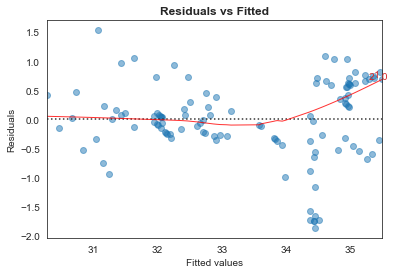

In [29]:
# use Linear Reg Diagnostics
lin = Linear_Reg_Diagnostic(model)
lin.residual_plot()

<AxesSubplot:title={'center':'Residuals vs Leverage'}, xlabel='Leverage', ylabel='Standardized Residuals'>

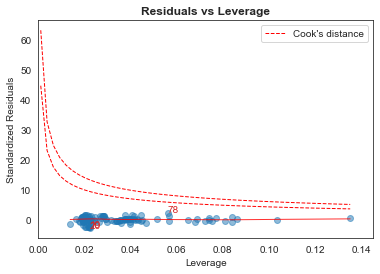

In [30]:
lin.leverage_plot()

In [31]:
lin.vif_table()

          Features  VIF Factor
3   ocean_sst_mean        1.01
1      mean_precip        1.06
2  estu_longintude        1.06
0        Intercept       37.14


## Question 3 

Using the `coal-production.csv` data, model the proportion of electricity produced with coal in high income countries over time with an ARIMA model. 

Process the data to be useable for time series analysis. (2 pt)

Display your data. Does it appear to have a trend? If so, describe the trend. (1 pt)

Test for stationarity. (1 pt)

Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. What type of ARIMA model was found to be the best fit? (2 pt)

Visualize the fitted values of the ARIMA model, being sure to label each line. (2 pt)

Make a forecast for 25 years after the conclusion of the time series and visualize with observed and fitted values. (2 pt)

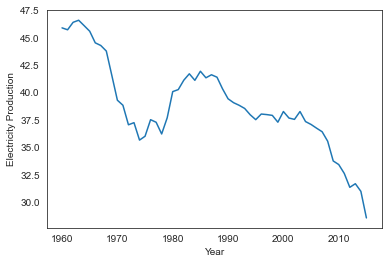

In [32]:
coal = pd.read_csv("data/coal-production.csv")
coal['year'] = pd.to_datetime(coal['year'], format='%Y')
coal = coal.set_index('year')

fig, ax = plt.subplots()
ax.plot(coal)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Production');

#### Does the data appear to have a trend?
The following trend was found in the data: The proportion of electricity produced with coal has been decreasing over time.

In [33]:
def adf_print(time_series):
    adf_output = adfuller(time_series)
    print('ADF Statistic:', adf_output[0])
    print('p-value:', adf_output[1])

adf_print(coal)

ADF Statistic: 1.8721544326758224
p-value: 0.9984818799941668


#### Test for stationarity
Because the p-value is a lot larger than 0.05, we can accept the null hypothesis that the data is not stationary.

In [34]:
auto_arima_model = auto_arima(coal['electricity_prod'])
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -71.684
Date:                Tue, 25 Apr 2023   AIC                            149.368
Time:                        17:50:09   BIC                            155.390
Sample:                    01-01-1960   HQIC                           151.697
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8478      0.140      6.074      0.000       0.574       1.121
ma.L1         -0.6020      0.230     -2.622      0.009      -1.052      -0.152
sigma2         0.7894      0.171      4.604      0.000       0.453       1.125
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.68   Prob(JB):                         0.51
Heteroskedasticity (H):               0.72   Skew:                             0.36
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### What type of ARIMA model was found to be the best fit?
The type of ARIMA model that was found to be the best fit was ARIMA(1,1,1).

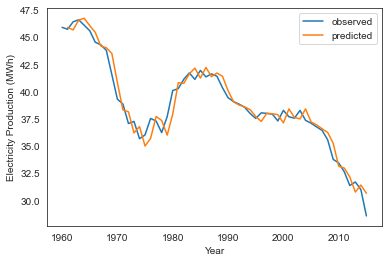

In [35]:
in_samp_pred = auto_arima_model.predict_in_sample()

fig, ax = plt.subplots()
ax.plot(coal, label='observed')
ax.plot(in_samp_pred[1:], label='predicted')
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Production (MWh)')
ax.legend()

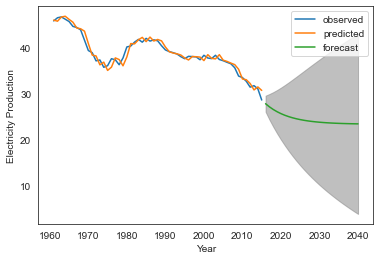

In [36]:
forecast, ci = auto_arima_model.predict(25, return_conf_int=True)

fig, ax = plt.subplots()
ax.plot(coal[1:], label='observed')
ax.plot(in_samp_pred[1:], label='predicted')
ax.plot(forecast, label='forecast')
ax.fill_between(forecast.index, ci[:,0], ci[:,1], color = 'gray', alpha=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Production')
ax.legend()